In [1]:
import os
import glob
import pickle
import tqdm
import functools
import multiprocessing
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import util_figures
import util_localization_psychophysics
import util_localization_psychophysics_figures
import util_spkr_word_psychophysics
import util_spkr_word_psychophysics_figures
import util


def get_p_val(y_null, y):
    """
    Estimate two-tailed p-value of obtaining a value of `y`
    (or more extreme) under the distribution `y_null`
    """
    null_dist = scipy.stats.norm(loc=np.mean(y_null), scale=np.std(y_null))
    p = null_dist.cdf(y)
    if p > 0.5:
        p = 1 - p
    p = p * 2
    return p


Loaded: data/model/sound_localization.pkl
Loaded: data/model/sound_localization_human_model_comparison_metrics.pkl


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

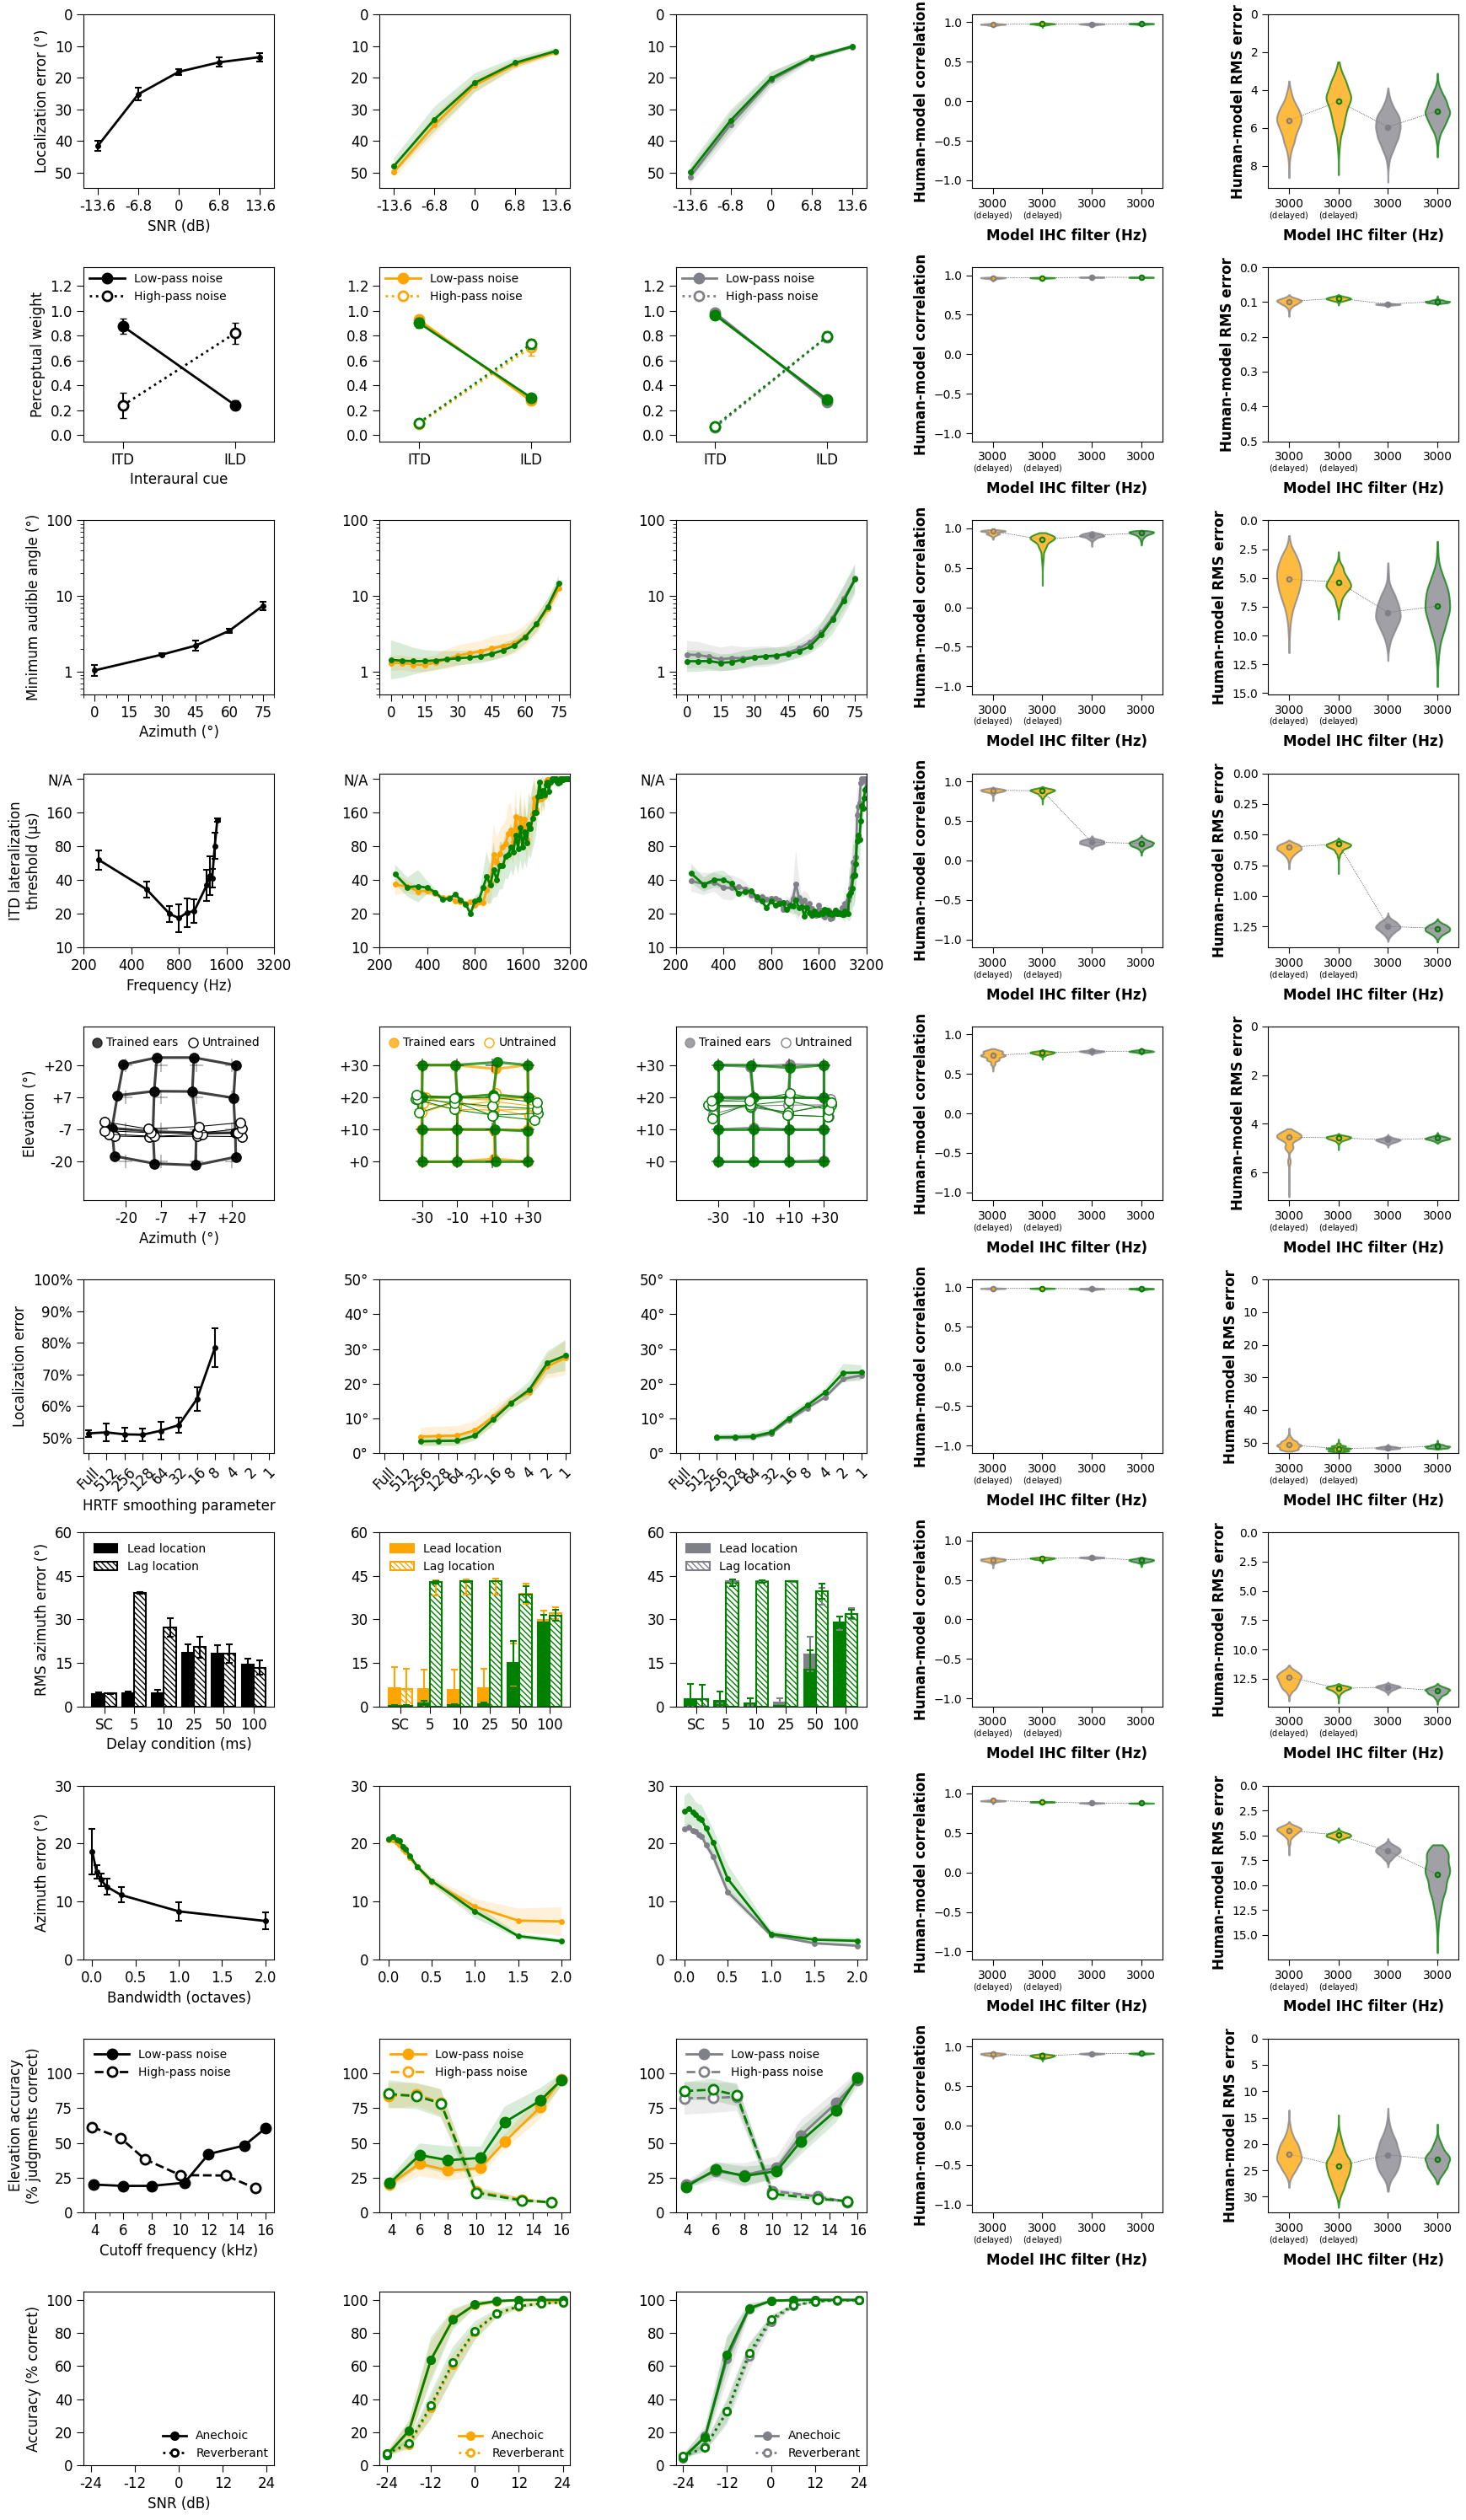

In [2]:
fn_data = "data/model/sound_localization.pkl"
fn_metrics = "data/model/sound_localization_human_model_comparison_metrics.pkl"

list_tag_model = [
    "human",
    "models/sound_localization/IHC3000_delayed_integration/arch??",
    "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
    "models/sound_localization/IHC3000/arch??",
    "models/sound_localization/sr20000_IHC3000/arch??",
]

with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
df_comparison = pd.read_pickle(fn_metrics)
print(f"Loaded: {fn_metrics}")

map_tag_expt_to_plot_func = {
    "snr_dependency": util_localization_psychophysics_figures.make_plot_snr_dependency,
    "itd_ild_weighting": util_localization_psychophysics_figures.make_plot_itd_ild_weighting,
    "maa_azimuth": util_localization_psychophysics_figures.make_plot_maa_azimuth,
    "itd_threshold": util_localization_psychophysics_figures.make_plot_itd_threshold,
    "new_ears": util_localization_psychophysics_figures.make_plot_new_ears,
    "spectral_smoothing": util_localization_psychophysics_figures.make_plot_spectral_smoothing,
    "precedence_effect_localization": util_localization_psychophysics_figures.make_plot_precedence_effect_localization,
    "bandwidth_dependency": util_localization_psychophysics_figures.make_plot_bandwidth_dependency,
    "mp_spectral_cues": util_localization_psychophysics_figures.make_plot_mp_spectral_cues,
    "speech_in_noise_in_reverb": util_localization_psychophysics_figures.make_plot_speech_in_noise_in_reverb,
}

list_key_metric = [
    "pearsonr",
    "rmse",
]
nrows = len(map_tag_expt_to_plot_func.keys())
ncols = len(list_tag_model) - 2 + len(list_key_metric)
figsize = (3.5 * ncols, 3 * nrows)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax_arr = ax_arr.reshape([nrows, ncols])
for c, tag_model in enumerate(list_tag_model):
    for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
        column = c
        if "IHC" in tag_model:
            column = 1 if "delayed" in tag_model else 2
        ax = ax_arr[r, column]
        df = EXPERIMENT_DATAFRAMES[tag_expt]
        color, _ = util.get_color_and_label_from_model_tag(tag_model)
        if "delayed" in tag_model:
            color = "orange"
        if "sr20000" in tag_model:
            color = "green"
        map_tag_expt_to_plot_func[tag_expt](
            ax,
            df[df.tag_model == tag_model],
            color=color,
            include_legend="sr20000" not in tag_model,
        )
        if c > 0:
            ax.xaxis.label.set_color("w")
            ax.yaxis.label.set_color("w")

for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    for itr_metric, key_metric in enumerate(list_key_metric):
        c = len(list_tag_model) - 2 + itr_metric
        ax = ax_arr[r, c]
        kwargs_format_axes_update = {
            "fontsize_ticks": 10,
            "fontweight_labels": "bold",
            "str_ylabel": r"Human-model correlation" if key_metric == "pearsonr" else "Human-model RMS error",
            "str_xlabel": "Model IHC filter (Hz)",
        }
        if key_metric == "pearsonr":
            kwargs_format_axes_update["ylimits"] = [-1.1, 1.1]
            kwargs_format_axes_update["yticks"] = [-1, -0.5, 0, 0.5, 1]
        if key_metric == "rmse":
            kwargs_format_axes_update["ylimits"] = [0, None]
        if len(df_comparison[df_comparison.tag_expt == tag_expt]) > 0:
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df_comparison[df_comparison.tag_expt == tag_expt],
                key_metric=key_metric,
                list_tag_model=list_tag_model[1:],
                kwargs_format_axes_update=kwargs_format_axes_update)
            if not key_metric == "pearsonr":
                ax.invert_yaxis()
            ylim = list(ax.get_ylim())
            if (key_metric == "rmse") and (ylim[0] < 0.5):
                ylim[0] = 0.5
                ax.set_ylim(ylim)
        else:
            ax.set_axis_off()
plt.tight_layout()
plt.show()


Loaded: data/model/spkr_word_recognition.pkl
Loaded: data/model/spkr_word_recognition_human_model_comparison_metrics.pkl


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


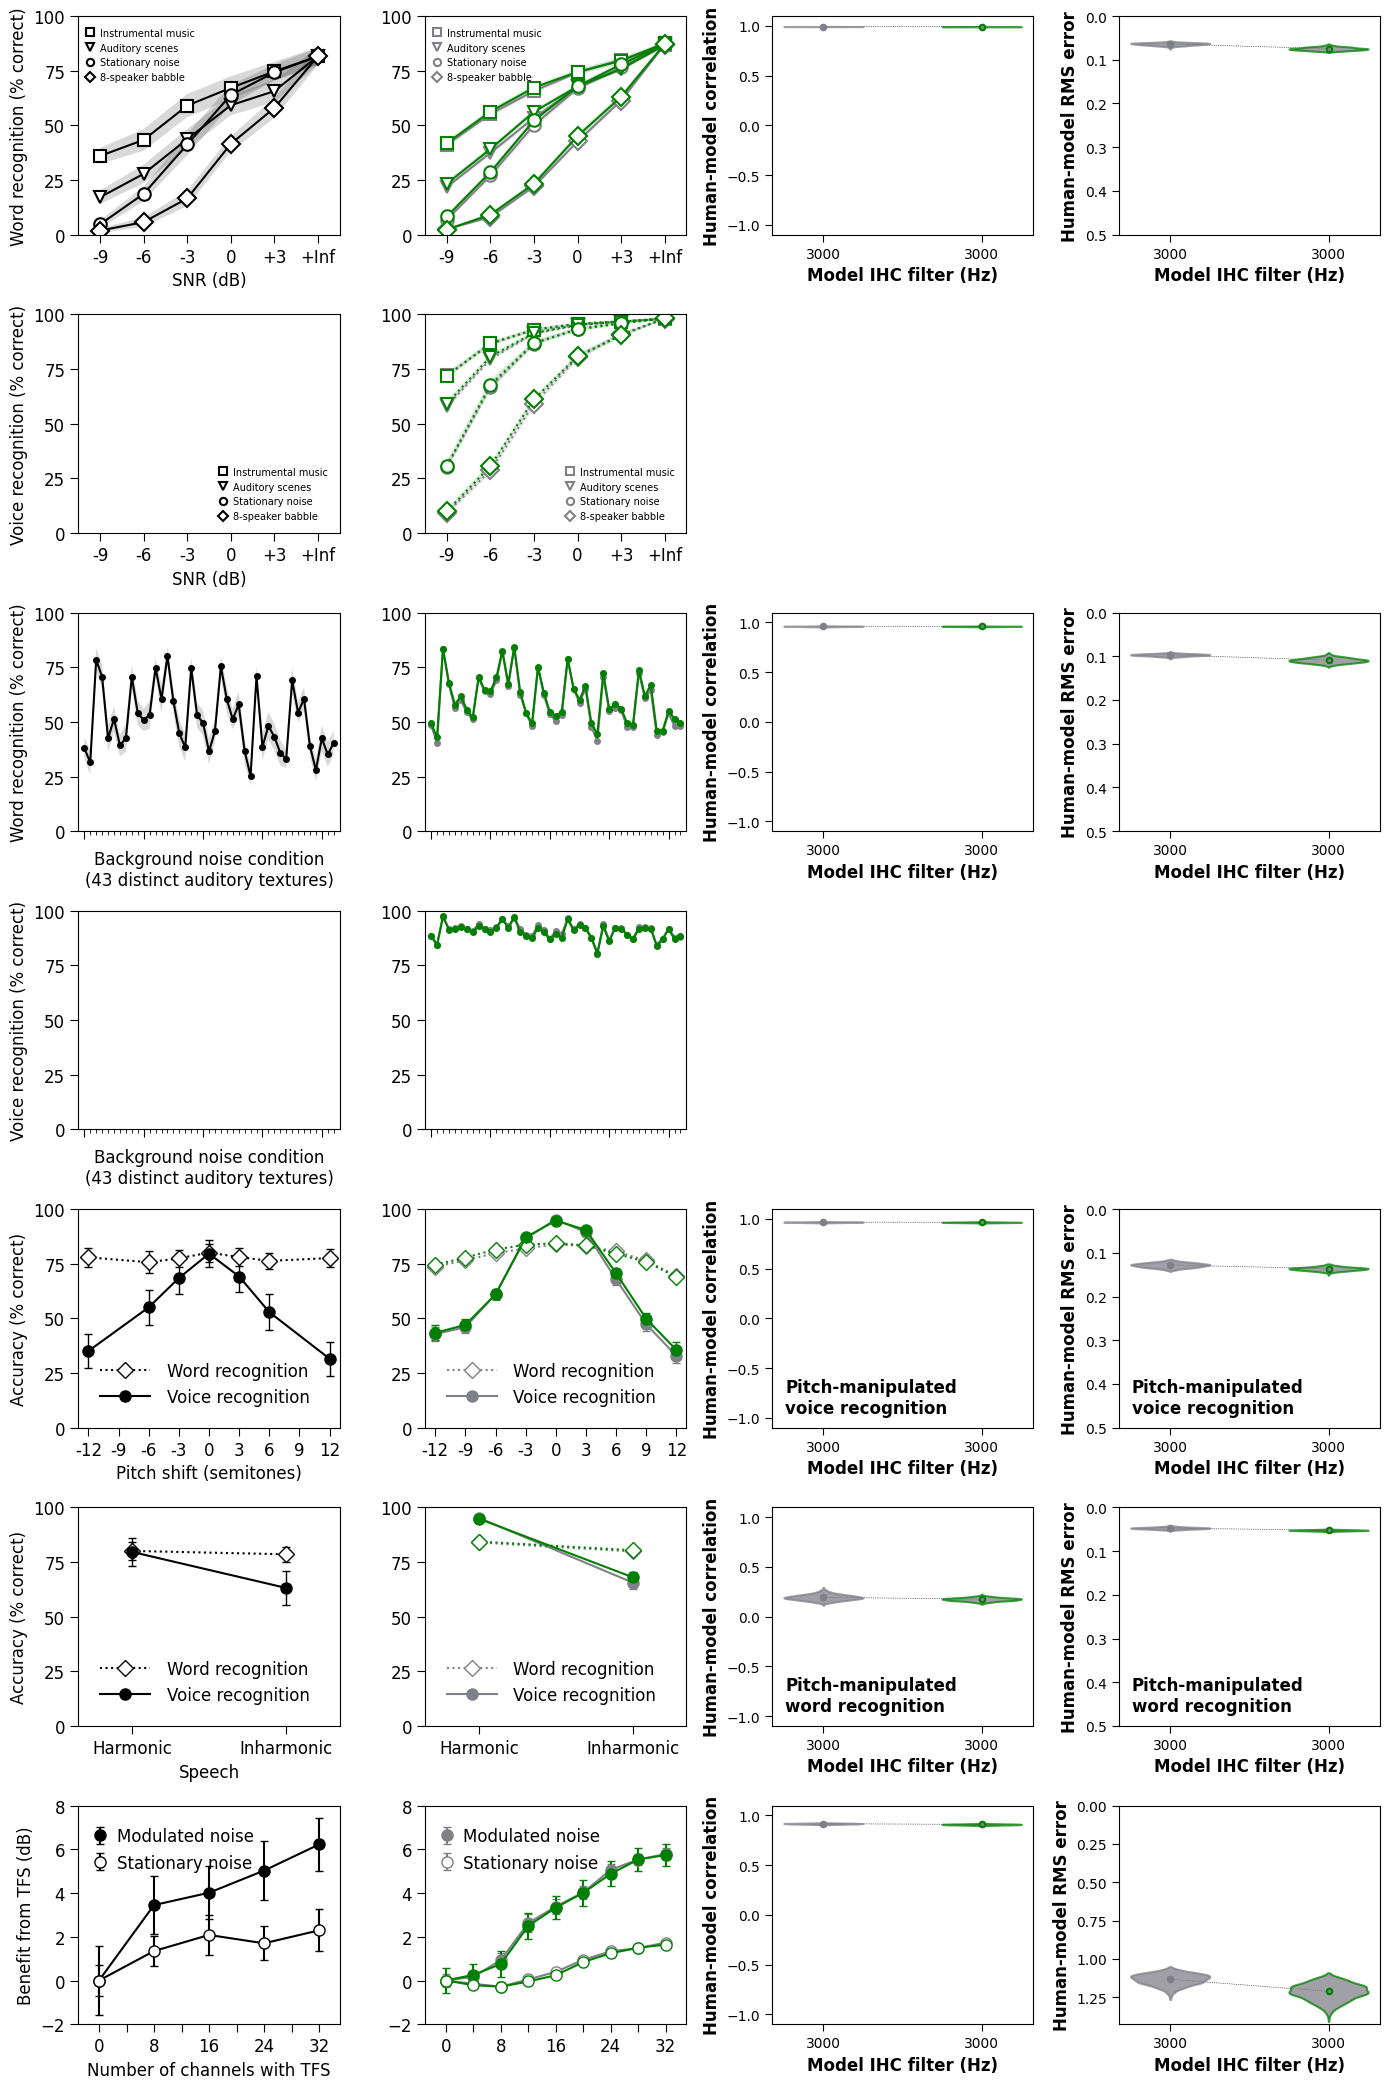

In [3]:
fn_data = "data/model/spkr_word_recognition.pkl"
fn_metrics = "data/model/spkr_word_recognition_human_model_comparison_metrics.pkl"

list_tag_model = [
    "human",
    "models/spkr_word_recognition/IHC3000/arch0_00??",
    "models/spkr_word_recognition/sr20000_IHC3000/arch0_00??",
]
SINGLE_TASK_MODELS = 0 # Set to 1 to automatically replace joint word/voice recognition models with single-task variants

with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
df_comparison = pd.read_pickle(fn_metrics)
print(f"Loaded: {fn_metrics}")

map_tag_expt_to_plot_func = {
    "kell_like_word": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task="word",
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1]),
    "kell_like_spkr": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task="spkr",
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1],
        kwargs_plot_update={"ls": ":"}),
    "speech_in_synthetic_textures_word": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures,
        key_task="word"),
    "speech_in_synthetic_textures_spkr": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures,
        key_task="spkr"),
    "pitch_shifted": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_shifted_recognition,
        key_task=["word", "spkr"]),
    "pitch_condition": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_condition_recognition,
        key_task=["word", "spkr"]),
    "hopkins_moore_2009_word": util_spkr_word_psychophysics_figures.make_plot_hopkins_moore_2009_tfs_benefit,
}

list_key_metric = [
    "pearsonr",
    "rmse",
]
nrows = len(map_tag_expt_to_plot_func.keys())
ncols = len(list_tag_model) - 1 + len(list_key_metric)
figsize = (3.5 * ncols, 3 * nrows)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax_arr = ax_arr.reshape([nrows, ncols])
for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    tag_expt_for_dataframe = tag_expt
    if "pitch" in tag_expt:
        tag_expt_for_dataframe = "pitch_altered"
    for suffix in ["_spkr", "_word", "_dip_listening"]:
        tag_expt_for_dataframe = tag_expt_for_dataframe.replace(suffix, "")
    for c, tag_model in enumerate(list_tag_model):
        color, _ = util.get_color_and_label_from_model_tag(tag_model)
        include_legend = not "sr20000" in tag_model
        if not include_legend:
            color = "green"
        ax = ax_arr[r, c - 1 if "sr20000" in tag_model else c]
        df = EXPERIMENT_DATAFRAMES[tag_expt_for_dataframe]
        if (not tag_model == "human") and (SINGLE_TASK_MODELS):
            if "spkr" in tag_expt:
                df = df[df.tag_model == tag_model.replace("spkr_word_recognition", "spkr_recognition")]
                map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, key_task="spkr", include_legend=include_legend)
            if "word" in tag_expt:
                df = df[df.tag_model == tag_model.replace("spkr_word_recognition", "word_recognition")]
                map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, key_task="word", include_legend=include_legend)
            if (not "spkr" in tag_expt) and (not "word" in tag_expt):
                df_merged = df[df.tag_model == tag_model.replace("spkr_word_recognition", "spkr_recognition")].copy()
                df_word = df[df.tag_model == tag_model.replace("spkr_word_recognition", "word_recognition")].copy()
                for column in df_word.columns:
                    if "word" in column:
                        df_merged.loc[:, column] = df_word[column].values
                map_tag_expt_to_plot_func[tag_expt](ax, df_merged, color=color, include_legend=include_legend)
        else:
            df = df[df.tag_model == tag_model]
            map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, include_legend=include_legend)
        if c > 0:
            ax.xaxis.label.set_color("w")
            ax.yaxis.label.set_color("w")

for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    for itr_metric, key_metric in enumerate(list_key_metric):
        c = len(list_tag_model) - 1 + itr_metric
        ax = ax_arr[r, c]
        list_tag_model_for_make_plot_comparison_metrics = list_tag_model[1:]
        tag_expt_for_dataframe = tag_expt
        if "pitch_shifted" in tag_expt:
            tag_expt_for_dataframe = "pitch_altered_spkr"
        elif "pitch_condition" in tag_expt:
            tag_expt_for_dataframe = "pitch_altered_word"
        elif "speech_in_synthetic_textures_word" in tag_expt:
            tag_expt_for_dataframe = "speech_in_synthetic_textures"
        if SINGLE_TASK_MODELS:
            list_tag_model_for_make_plot_comparison_metrics = [
                _.replace(
                    "spkr_word_recognition",
                    "spkr_recognition" if "spkr" in tag_expt_for_dataframe else "word_recognition",
                )
                for _ in list_tag_model_for_make_plot_comparison_metrics
            ]
        kwargs_format_axes_update = {
            "fontsize_ticks": 10,
            "fontweight_labels": "bold",
            "str_ylabel": r"Human-model correlation" if key_metric == "pearsonr" else "Human-model RMS error",
            "str_xlabel": "Model IHC filter (Hz)",
        }
        if key_metric == "pearsonr":
            kwargs_format_axes_update["ylimits"] = [-1.1, 1.1]
            kwargs_format_axes_update["yticks"] = [-1, -0.5, 0, 0.5, 1]
        if key_metric == "rmse":
            kwargs_format_axes_update["ylimits"] = [0, None]
        if len(df_comparison[df_comparison.tag_expt == tag_expt_for_dataframe]) > 0:
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df_comparison[df_comparison.tag_expt == tag_expt_for_dataframe],
                key_metric=key_metric,
                list_tag_model=list_tag_model_for_make_plot_comparison_metrics,
                kwargs_format_axes_update=kwargs_format_axes_update)
            if not key_metric == "pearsonr":
                ax.invert_yaxis()
            kwargs_text = {"ha": "left", "va": "bottom", "transform": ax.transAxes, "fontsize":12, "fontweight": "bold"}
            if tag_expt_for_dataframe == "pitch_altered_word":
                ax.text(0.05, 0.05, "Pitch-manipulated\nword recognition", **kwargs_text)
            if tag_expt_for_dataframe == "pitch_altered_spkr":
                ax.text(0.05, 0.05, "Pitch-manipulated\nvoice recognition", **kwargs_text)
            ylim = list(ax.get_ylim())
            if (key_metric == "rmse") and (ylim[0] < 0.5):
                ylim[0] = 0.5
                ax.set_ylim(ylim)
        else:
            ax.set_axis_off()
plt.tight_layout()
plt.show()


In [4]:
# with open("data/model/sound_localization.pkl", "rb") as f:
#     EXPERIMENT_DATAFRAMES = pickle.load(f)

# map_k_to_tag_model = {
#     "human": "human",
#     "sr20000_3000_delayed": "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
#     "sr20000_3000": "models/sound_localization/sr20000_IHC3000/arch??",
#     "3000_delayed": "models/sound_localization/IHC3000_delayed_integration/arch??",
#     "3000": "models/sound_localization/IHC3000/arch??",
#     "1000": "models/sound_localization/IHC1000/arch??",
#     "320": "models/sound_localization/IHC0320/arch??",
#     "50": "models/sound_localization/IHC0050/arch??",
# }

# df_results = EXPERIMENT_DATAFRAMES["snr_dependency"]
# list_k_model = [
#     # "human",
#     "sr20000_3000_delayed",
#     "sr20000_3000",
#     "3000_delayed",
#     "3000",
#     "1000",
#     # "320",
#     # "50",
# ]
# dict_key_metric = {
#     "deg_err": {
#         "str_title": "Spherical error",
#         "ylimits": [60, 0],
#         "yticks": [60, 45, 30, 15, 0],
#     },
#     "deg_azim_err": {
#         "str_title": "Azimuth error",
#         "ylimits": [60, 0],
#         "yticks": [60, 45, 30, 15, 0],
#     },
#     "deg_elev_err": {
#         "str_title": "Elevation error",
#         "ylimits": [20, 0],
#         "yticks": [20, 15, 10, 5, 0],
#     },
# }
# nrows = 1
# ncols = len(dict_key_metric)
# fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8.5, 3.0))

# for itr_ax, key_metric in enumerate(dict_key_metric.keys()):
#     ax = ax_arr[itr_ax]
#     for itr_model, k_model in enumerate(list_k_model):
#         tag_model = map_k_to_tag_model[k_model]
#         # color, label = util.get_color_and_label_from_model_tag(tag_model)
#         label = k_model
#         color = util_figures.get_color_list(5)[itr_model]
#         dfi = df_results[np.logical_and.reduce([
#             df_results.tag_model == tag_model
#         ])]
#         if "pool" in tag_model:
#             color = "orange"
#             label = None
#         kwargs_format_axes_update = {
#             "fontweight_title": "bold",
#             "fontsize_ticks": 10,
#             "str_ylabel": "Mean absolute error (°)" if itr_ax == 0 else None,
#             "str_xlabel": "SNR (dB)" if itr_ax == 0 else None,
#         }
#         kwargs_format_axes_update.update(dict_key_metric[key_metric])
#         kwargs_plot_update = {
#             "color": color,
#             "label": label,
#         }
#         ax = util_localization_psychophysics_figures.make_plot_snr_dependency(
#             ax,
#             dfi,
#             key_metric=key_metric,
#             kwargs_plot_update=kwargs_plot_update,
#             kwargs_format_axes_update=kwargs_format_axes_update)
#     if itr_ax == 1:
#         kwargs_legend = {
#             "loc": "lower right",
#             "borderpad": 0.5,
#             "borderaxespad": 0,
#             "frameon": False,
#             "framealpha": 1.0,
#             "facecolor": "w",
#             "edgecolor": "k",
#             "handlelength": 0,
#             "markerscale": 2.0,
#             "fontsize": 8.5,
#         }
#         ax.legend(**kwargs_legend)
# plt.tight_layout()
# plt.show()


In [5]:
# list_tag_model = [
#     "sr20000_IHC3000_delayed_integration",
#     "sr20000_IHC3000",
#     "IHC3000_delayed_integration",
#     "IHC3000",
# ]
# fig, ax_arr = plt.subplots(
#     nrows=1,
#     ncols=len(list_tag_model),
#     figsize=(4 * len(list_tag_model), 4),
# )
# for itr_ax, tag_model in enumerate(list_tag_model):
#     list_dir_model = glob.glob(f"models/sound_localization/{tag_model}/arch??")
#     for dir_model in list_dir_model:
#         df = pd.read_csv(os.path.join(dir_model, "log_optimize.csv"))
#         ax_arr[itr_ax].plot(df.epoch, df.val_accuracy)
#     util_figures.format_axes(
#         ax_arr[itr_ax],
#         ylimits=[0, 0.4],
#         str_xlabel="epoch",
#         str_ylabel="valid_acc",
#         str_title=tag_model,
#     )
# plt.tight_layout()
# plt.show()



Comparing TASK `spkr` METRIC `pearsonr` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.7456, cohen_d=-0.4709 <==


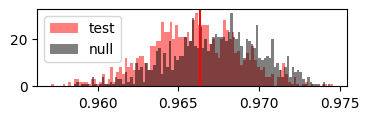


Comparing TASK `spkr` METRIC `correct_spkr` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.0627, cohen_d=1.4109 <== 75.26196808510637 75.71808510638297


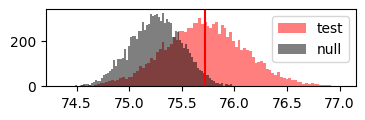


Comparing TASK `word` METRIC `pearsonr` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.2933, cohen_d=-1.3238 <==


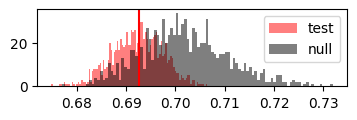


Comparing TASK `word` METRIC `correct_word` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.0003, cohen_d=3.2444 <== 46.82845744680851 47.993351063829785


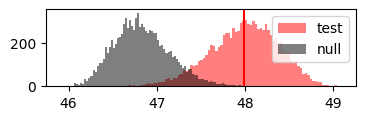

In [6]:
tag_model_ref = "models/spkr_word_recognition/IHC3000/arch0_00??"
tag_model_cmp = "models/spkr_word_recognition/sr20000_IHC3000/arch0_00??"

for key_task in ["spkr", "word"]:
    key_metric_comparison = "pearsonr"
    key_metric_performance = f"correct_{key_task}"
    
    df = pd.read_pickle("data/model/spkr_word_recognition_human_model_comparison_metrics.pkl")
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
        df.tag_expt.str.contains(key_task),
        ~df.tag_expt.str.contains("spkr_word"), # Removes comparisons of speaker + word task together
    ])]
    df = util.normalize_comparison_metrics(df)
    df = util.average_comparison_metrics(df)
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_comparison}"]
    p_val = get_p_val(y_null, y_test)
    print("\nComparing TASK `{}` METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <==".format(
        key_task,
        key_metric_comparison,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()
    
    
    with open("data/model/spkr_word_recognition.pkl", "rb") as f:
        df = pickle.load(f)["kell_like"]
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
        df.snr.isin([-9, -6, -3, 0, 3]),
        df.background_condition.isin([0, 1, 2, 3]),
    ])]
    df = df.groupby(["tag_model"]).agg({f"{key_metric_performance}_list": list}).reset_index()
    df[f"{key_metric_performance}_list"] = df[f"{key_metric_performance}_list"].map(lambda _: np.array(_).mean(axis=0))
    df[f"{key_metric_performance}_list"] = df[f"{key_metric_performance}_list"].map(lambda _: 100 * np.array(_))
    df[f"{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(lambda _: np.mean(_))
    df[f"bootstrap_list_{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(
        lambda _: np.random.choice(_, size=(10000, len(_))).mean(axis=1))
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_performance}"]
    y_ref = df[df.tag_model == tag_model_ref].iloc[0][f"{key_metric_performance}"]
    p_val = get_p_val(y_null, y_test)
    print("\nComparing TASK `{}` METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <== {} {}".format(
        key_task,
        key_metric_performance,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
        y_ref,
        y_test,
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()



Comparing METRIC `pearsonr` between:
|__ models/sound_localization/IHC3000/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000/arch??
==> RESULT: p=0.9994, cohen_d=-0.5150 <==


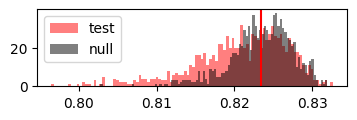


Comparing METRIC `deg_err` between:
|__ models/sound_localization/IHC3000/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000/arch??
==> RESULT: p=0.3986, cohen_d=-0.8835 <==


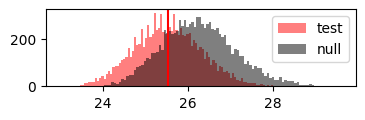


Comparing METRIC `pearsonr` between:
|__ models/sound_localization/IHC3000_delayed_integration/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000_delayed_integration/arch??
==> RESULT: p=0.3583, cohen_d=-1.1037 <==


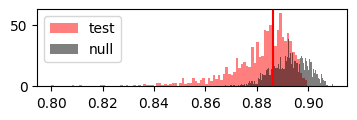


Comparing METRIC `deg_err` between:
|__ models/sound_localization/IHC3000_delayed_integration/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000_delayed_integration/arch??
==> RESULT: p=0.1977, cohen_d=-1.1289 <==


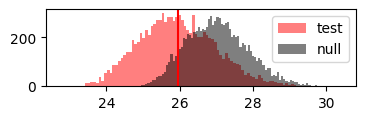

In [7]:
list_tag_pair = [
    ("models/sound_localization/IHC3000/arch??", "models/sound_localization/sr20000_IHC3000/arch??"),
    ("models/sound_localization/IHC3000_delayed_integration/arch??", "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??"),
]

for tag_model_ref, tag_model_cmp in list_tag_pair:
    key_metric_comparison = "pearsonr"
    key_metric_performance = "deg_err"

    df = pd.read_pickle("data/model/sound_localization_human_model_comparison_metrics.pkl")
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
    ])]
    df = util.normalize_comparison_metrics(df)
    df = util.average_comparison_metrics(df)
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_comparison}"]
    p_val = get_p_val(y_null, y_test)
    print("\nComparing METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <==".format(
        key_metric_comparison,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()


    with open("data/model/sound_localization.pkl", "rb") as f:
        df = pickle.load(f)["snr_dependency"]
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
        np.isfinite(df.snr),
    ])]
    df = df.groupby(["tag_model"]).agg({f"{key_metric_performance}_list": list}).reset_index()
    df[f"{key_metric_performance}_list"] = df[f"{key_metric_performance}_list"].map(lambda _: np.array(_).mean(axis=0))
    df[f"{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(lambda _: np.mean(_))
    df[f"bootstrap_list_{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(
        lambda _: np.random.choice(_, size=(10000, len(_))).mean(axis=1))
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_performance}"]
    p_val = get_p_val(y_null, y_test)
    print("\nComparing METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <==".format(
        key_metric_performance,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()


['human', '3000_simple', '1000_simple', '320_simple', '50_simple']


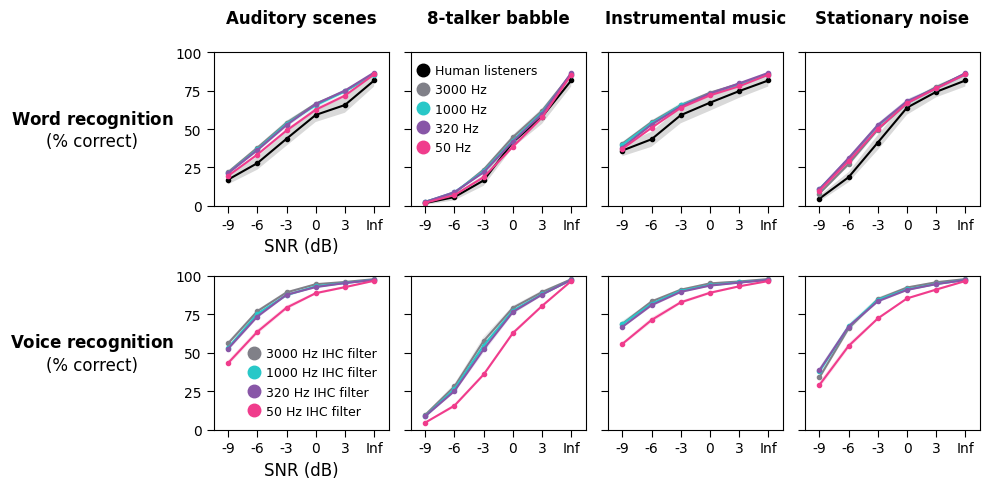

['human', '3000_simple_autocorr_concat', '1000_simple_autocorr_concat', '320_simple_autocorr_concat', '50_simple_autocorr_concat', '3000_simple']


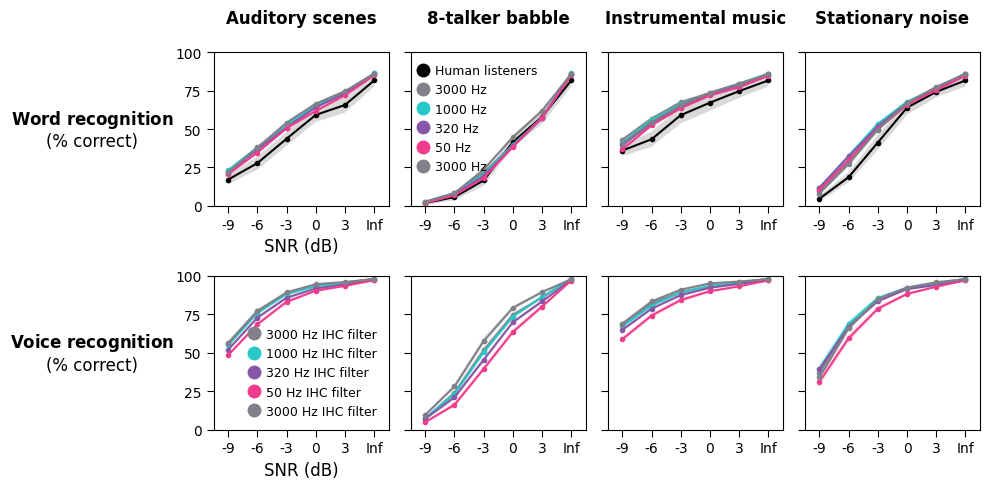

['human', '3000_simple_autocorr_input', '1000_simple_autocorr_input', '320_simple_autocorr_input', '50_simple_autocorr_input', '3000_simple']


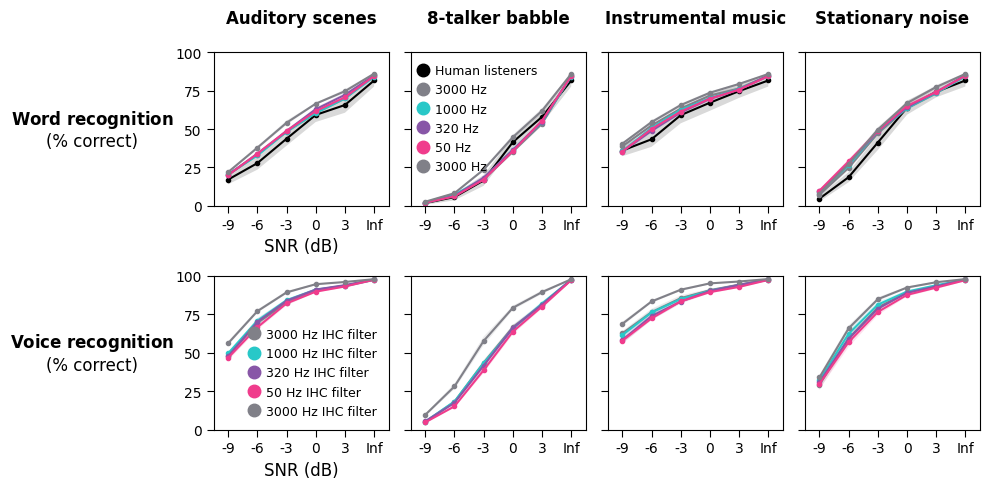

In [3]:
fn_data = "/om2/user/msaddler/phaselocknet/data/model/simplified_spkr_word_recognition.pkl"
with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)

map_k_to_tag_model = {
    "human": "human",
    "3000_simple": "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
    "1000_simple": "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
    "320_simple": "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
    "50_simple": "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
    "3000_simple_autocorr_concat": "models/spkr_word_recognition/autocorr_block3concat/simplified_IHC3000/arch0_00??",
    "1000_simple_autocorr_concat": "models/spkr_word_recognition/autocorr_block3concat/simplified_IHC1000/arch0_00??",
    "320_simple_autocorr_concat": "models/spkr_word_recognition/autocorr_block3concat/simplified_IHC0320/arch0_00??",
    "50_simple_autocorr_concat": "models/spkr_word_recognition/autocorr_block3concat/simplified_IHC0050/arch0_00??",
    "3000_simple_autocorr_input": "models/spkr_word_recognition/autocorr_block3input/simplified_IHC3000/arch0_00??",
    "1000_simple_autocorr_input": "models/spkr_word_recognition/autocorr_block3input/simplified_IHC1000/arch0_00??",
    "320_simple_autocorr_input": "models/spkr_word_recognition/autocorr_block3input/simplified_IHC0320/arch0_00??",
    "50_simple_autocorr_input": "models/spkr_word_recognition/autocorr_block3input/simplified_IHC0050/arch0_00??",

}

tag_expt = "kell_like"
df_results = EXPERIMENT_DATAFRAMES[tag_expt]
list_list_k_model = [
    ["human", "3000_simple", "1000_simple", "320_simple", "50_simple"],
    ["human", "3000_simple_autocorr_concat", "1000_simple_autocorr_concat", "320_simple_autocorr_concat", "50_simple_autocorr_concat", "3000_simple"],
    ["human", "3000_simple_autocorr_input", "1000_simple_autocorr_input", "320_simple_autocorr_input", "50_simple_autocorr_input", "3000_simple"],
]
list_key_task = [
    "word",
    "spkr",
]
list_condition_title = [
    (0, "Auditory\nscenes"),
    (1, "8-talker\nbabble"),
    (2, "Instrumental\nmusic"),
    (3, "Stationary\nnoise"),
]
for list_k_model in list_list_k_model:
    print(list_k_model)
    fig, ax_arr = plt.subplots(
        nrows=len(list_key_task),
        ncols=4,
        figsize=(10, 2.5 * len(list_key_task)),
        sharey=True)
    for r, key_task in enumerate(list_key_task):
        for c, (condition, str_title) in enumerate(list_condition_title):
            ax = ax_arr[r, c]
            for k in list_k_model:
                tag_model = map_k_to_tag_model[k]
                color, label = util.get_color_and_label_from_model_tag(tag_model)
                df = df_results[df_results.tag_model == tag_model]
                kwargs_plot_update = {
                    "marker": ".",
                    "ms": 6,
                    "mfc": color,
                    "mew": 1,
                    "lw": 1.5,
                    "label": label,
                }
                str_ylabel = "{} recognition\n(% correct)".format("Word" if key_task == "word" else "Voice")
                kwargs_format_axes_update = {
                    "str_ylabel": str_ylabel if c == 0 else None,
                    "str_xlabel": "SNR (dB)" if c == 0 else None,
                    "fontsize_ticks": 10,
                    "xticklabels": [-9, -6, -3, 0, 3, "Inf"],
                    "str_title": str_title.replace("\n", " ") + "\n" if r == 0 else None,
                    "fontweight_title": "bold"
                }
                kwargs_legend_update = {
                    "loc": "lower right",
                    "markerscale": 3,
                    "borderaxespad": 0.75,
                    "fontsize": 9,
                }
                include_legend = condition == 0
                if (key_task == "word") or ("inharmonic" in tag_expt):
                    include_legend = condition == 1
                    kwargs_legend_update["loc"] = "upper left"
                    kwargs_plot_update["label"] = label.replace(" IHC filter", "")
                if (k == "human") and (key_task == "spkr"):
                    pass
                else:
                    ax = util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition(
                        ax,
                        df,
                        key_task=key_task,
                        restrict_background_condition=[condition],
                        include_legend=include_legend,
                        color=color,
                        kwargs_plot_update=kwargs_plot_update,
                        kwargs_legend_update=kwargs_legend_update,
                        kwargs_format_axes_update=kwargs_format_axes_update,
                    )
            str_ylabel = "{}".format("Word" if key_task == "word" else "Voice")
            str_ylabel = r"$\bf{" + str_ylabel + "}$" + r" $\bf{recognition}$"
            str_ylabel += "\n(% correct)"
            ax_arr[r, 0].set_ylabel(str_ylabel, rotation=0, ha="center", va="center", labelpad=60)
    plt.tight_layout()
    plt.show()


['human', '3000_simple', '1000_simple', '320_simple', '50_simple']


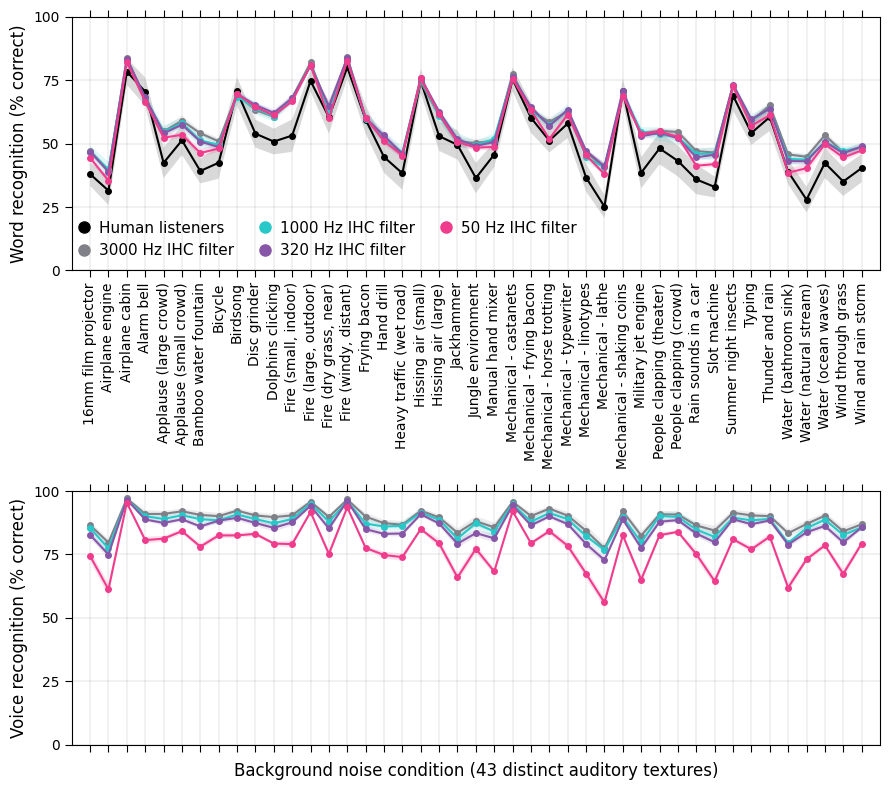

['human', '3000_simple_autocorr_concat', '1000_simple_autocorr_concat', '320_simple_autocorr_concat', '50_simple_autocorr_concat', '3000_simple']


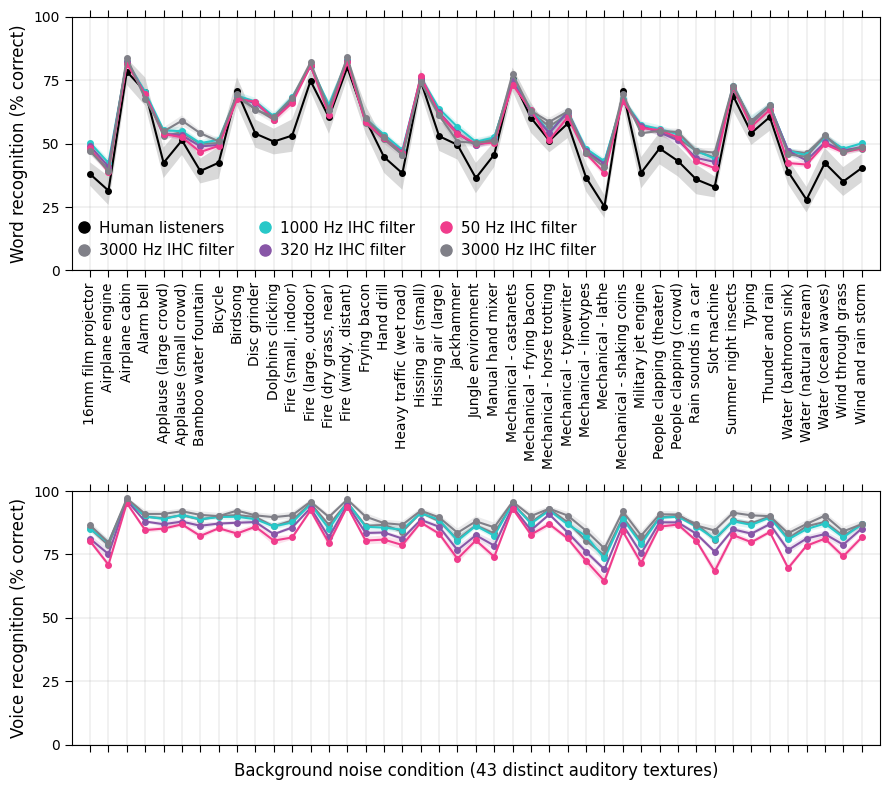

['human', '3000_simple_autocorr_input', '1000_simple_autocorr_input', '320_simple_autocorr_input', '50_simple_autocorr_input', '3000_simple']


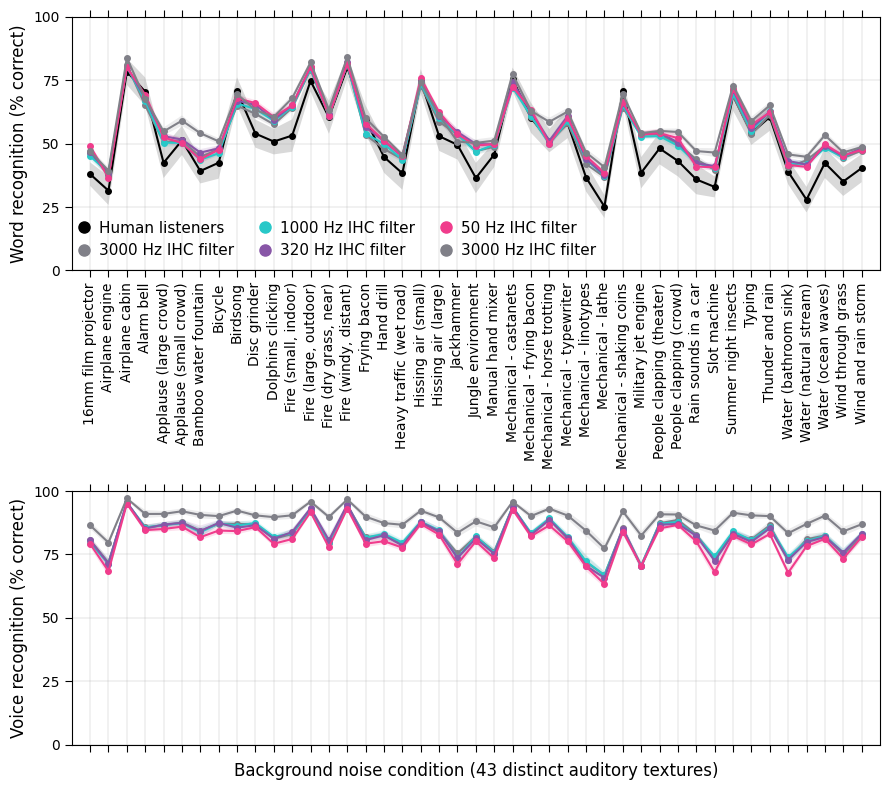

In [4]:
df_results = EXPERIMENT_DATAFRAMES["speech_in_synthetic_textures"]
list_list_k_model = [
    ["human", "3000_simple", "1000_simple", "320_simple", "50_simple"],
    ["human", "3000_simple_autocorr_concat", "1000_simple_autocorr_concat", "320_simple_autocorr_concat", "50_simple_autocorr_concat", "3000_simple"],
    ["human", "3000_simple_autocorr_input", "1000_simple_autocorr_input", "320_simple_autocorr_input", "50_simple_autocorr_input", "3000_simple"],
]
list_key_task = [
    "word",
    "spkr",
]
map_int_to_label = {
    0: "16mm film projector",
    1: "Airplane engine",
    2: "Airplane cabin",
    3: "Alarm bell",
    4: "Applause (large crowd)",
    5: "Applause (small crowd)",
    6: "Bamboo water fountain",
    7: "Bicycle",
    8: "Birdsong",
    9: "Disc grinder",
    10: "Dolphins clicking",
    11: "Fire (small, indoor)",
    12: "Fire (large, outdoor)",
    13: "Fire (dry grass, near)",
    14: "Fire (windy, distant)",
    15: "Frying bacon",
    16: "Hand drill",
    17: "Heavy traffic (wet road)",
    18: "Hissing air (small)",
    19: "Hissing air (large)",
    20: "Jackhammer",
    21: "Jungle environment",
    22: "Manual hand mixer",
    23: "Mechanical - castanets",
    24: "Mechanical - frying bacon",
    25: "Mechanical - horse trotting",
    26: "Mechanical - typewriter",
    27: "Mechanical - linotypes",
    28: "Mechanical - lathe",
    29: "Mechanical - shaking coins",
    30: "Military jet engine",
    31: "People clapping (theater)",
    32: "People clapping (crowd)",
    33: "Rain sounds in a car",
    34: "Slot machine",
    35: "Summer night insects",
    36: "Typing",
    37: "Thunder and rain",
    38: "Water (bathroom sink)",
    39: "Water (natural stream)",
    40: "Water (ocean waves)",
    41: "Wind through grass",
    42: "Wind and rain storm",
}
xticks = np.arange(len(map_int_to_label)).astype(int)
xticklabels = [map_int_to_label[_] for _ in xticks]
for list_k_model in list_list_k_model:
    print(list_k_model)
    fig, ax_arr = plt.subplots(nrows=len(list_key_task), ncols=1, figsize=(9, 8))
    for itr_ax, key_task in enumerate(list_key_task):
        ax = ax_arr[itr_ax]
        for itr_model, k in enumerate(list_k_model):
            tag_model = map_k_to_tag_model[k]
            color, label = util.get_color_and_label_from_model_tag(tag_model)
            df = df_results[df_results.tag_model == tag_model]
            kwargs_plot_update = {
                "label": label,
            }
            kwargs_legend_update = {
                "fontsize": 11,
                "handlelength": 0,
                "markerscale": 2,
                "ncols": 3,
                "borderaxespad": 0.5,
                "loc": "lower left",
            }
            kwargs_format_axes_update = {
                "fontsize_ticks": 10,
                "xticks": xticks,
                "xticklabels": xticklabels if itr_ax == 0 else [],
                "str_xlabel": "Background noise condition (43 distinct auditory textures)" if itr_ax == 1 else None,
                "major_tick_params_kwargs_update": {"top": True},
            }
            if len(df) > 0:
                ax = util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures(
                    ax,
                    df,
                    key_task=key_task,
                    color=color,
                    kwargs_plot_update=kwargs_plot_update,
                    kwargs_legend_update=kwargs_legend_update,
                    kwargs_format_axes_update=kwargs_format_axes_update,
                    include_legend=key_task=="word")
        if itr_ax == 0:
            ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
        ax.grid(lw=0.25)
    plt.tight_layout()
    plt.show()
